#### Bayesian kernel regression with Metropolis algorithm

Similarly, we replace Taylor approximation and Laplace's method in `10` with Metropolis algorithm for Bayesian kernel regression

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

np.set_printoptions(formatter={'float': '{: 0.2e}'.format})

#### Generate some data

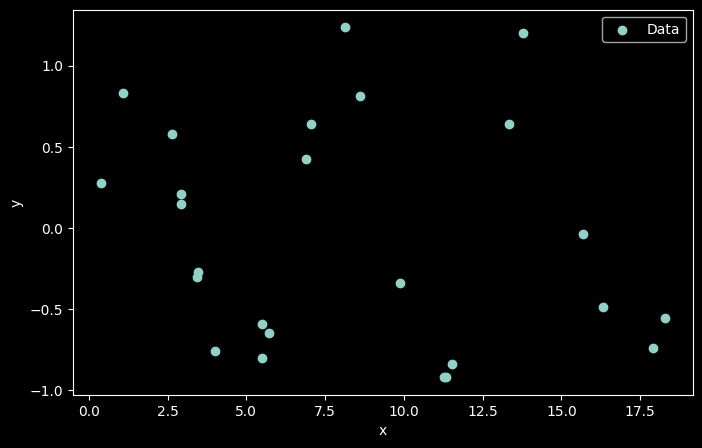

In [ ]:
# Generate data
np.random.seed(42)

num_points = 25

x = np.random.uniform(0, 6 * np.pi, num_points)

# True standard deviation of noise in measured y, only used in generating data
sigma_d_true = 0.1

# Guessed standard deviation of noise in measured y, only used in model
sigma_d = 0.1

# Guessed standard deviation of prior on weights, only used in model
sigma_theta = 0.5

# Kernel parameters
sigma_k = 0.9

y = np.sin(x) + np.random.normal(0, sigma_d_true, size=x.shape)

fig_0, ax_0 = plt.subplots(figsize=(8, 5))
ax_0.scatter(x, y, label='Data')
ax_0.set_xlabel('x')
ax_0.set_ylabel('y')
ax_0.legend()
plt.show()

In [ ]:
# Define RBF kernel function
def rbf_kernel(x_set_1, x_set_2, sigma_k):
    if np.ndim(x_set_2) == 1:
        x_set_2 = x_set_2.reshape(-1, 1)
    if np.ndim(x_set_1) == 1:
        x_set_1 = x_set_1.reshape(-1, 1)
    num_rows = x_set_1.shape[0]
    num_cols = x_set_2.shape[0]
    k_mat = np.zeros((num_rows, num_cols))
    for i in range(num_rows):
        for j in range(num_cols):
            sq_dist = np.sum((x_set_1[i,:] - x_set_2[j,:])**2)
            k_mat[i, j] = np.exp(-sq_dist / (2 * sigma_k**2))
    return k_mat

#### Virtual samples for training data points, based on eigendecomposition

In [ ]:
# Compute kernel matrix
x_k = rbf_kernel(x, x, sigma_k)
print(f'x_k: {x_k.shape}\n{x_k[:5,:5]}')

# Eigendecomposition
eigenvalues, eigenvectors = np.linalg.eigh(x_k)

print(f'eigenvalues: {eigenvalues.shape}')
print(f'eigenvectors: {eigenvectors.shape}')

# Virtual samples for training
threshold = 1e-10
mask = eigenvalues > threshold
eigenvalues = eigenvalues[mask]
eigenvectors = eigenvectors[:, mask]
print(f'eigenvalues after thresholding (if needed): {eigenvalues.shape}')
print(f'eigenvectors after thresholding (if needed): {eigenvectors.shape}')
v_samples_train = eigenvectors @ np.diag(np.sqrt(eigenvalues))

print(f'v_samples_train @ v_samples_train.T: \n{(v_samples_train @ v_samples_train.T)[:5,:5]}')
print(f'virtual samples shape: {v_samples_train.shape}')
print(v_samples_train[:5,:5])


x_k: (25, 25)
[[ 1.00e+00  2.39e-32  6.75e-13  1.64e-05  2.83e-05]
 [ 2.39e-32  1.00e+00  2.78e-05  1.56e-12  7.00e-61]
 [ 6.75e-13  2.78e-05  1.00e+00  2.03e-02  2.52e-32]
 [ 1.64e-05  1.56e-12  2.03e-02  1.00e+00  2.17e-19]
 [ 2.83e-05  7.00e-61  2.52e-32  2.17e-19  1.00e+00]]
eigenvalues: (25,)
eigenvectors: (25, 25)
eigenvalues after thresholding (if needed): (24,)
eigenvectors after thresholding (if needed): (25, 24)
v_samples_train @ v_samples_train.T: 
[[ 1.00e+00 -6.17e-17  6.75e-13  1.64e-05  2.83e-05]
 [-6.17e-17  1.00e+00  2.78e-05  1.56e-12 -2.90e-16]
 [ 6.75e-13  2.78e-05  1.00e+00  2.03e-02  3.39e-16]
 [ 1.64e-05  1.56e-12  2.03e-02  1.00e+00  7.52e-16]
 [ 2.83e-05 -2.90e-16  3.39e-16  7.52e-16  1.00e+00]]
virtual samples shape: (25, 24)
[[-3.52e-06  1.33e-05  5.98e-05 -2.12e-02  1.37e-02]
 [ 4.64e-10 -2.31e-09 -8.37e-07 -4.16e-06  5.74e-06]
 [-8.40e-09  4.18e-08  1.49e-05  6.98e-05 -9.04e-05]
 [-2.30e-06  1.11e-05  2.61e-03 -7.20e-06  4.26e-04]
 [-2.28e-06 -1.93e-05  4.9

#### Gradient descent to find $\theta_{MAP}$ (or $\theta_{ML}$)

In [ ]:
learning_rate = 0.00001
iterations = 10000

# Initial guess for parameters in feature space
theta = np.zeros(v_samples_train.shape[1])

In [ ]:
# Gradient descent to find MAP estimate
for k in range(iterations):
    y_pred = v_samples_train @ theta
    prior_theta = np.mean(theta**2) / sigma_theta**2
    likelihood = np.mean((y_pred - y)**2) / sigma_d**2
    loss = prior_theta + likelihood

    grad_prior_theta = theta / sigma_theta**2
    grad_likelihood = v_samples_train.T @ (y_pred - y) / sigma_d**2
    grad_loss = grad_prior_theta + grad_likelihood

    theta -= learning_rate * grad_loss

    if k % (iterations // 10) == 0:
        print(f"Iteration {k}: loss = {loss:.4f}")

theta_map = theta # this is theta_ml if theta is uniformly distributed
print(f"MAP estimate of parameters: {theta_map}")

Iteration 0: loss = 46.1603
Iteration 1000: loss = 2.8091
Iteration 2000: loss = 1.7602
Iteration 3000: loss = 1.5681
Iteration 4000: loss = 1.4760
Iteration 5000: loss = 1.4209
Iteration 6000: loss = 1.3854
Iteration 7000: loss = 1.3616
Iteration 8000: loss = 1.3453
Iteration 9000: loss = 1.3339
MAP estimate of parameters: [-4.63e-04  3.85e-04  1.03e-04  9.34e-03  4.32e-02 -2.20e-02 -1.27e-01
 -1.23e-01  2.21e-01 -3.62e-02  5.03e-01  5.17e-01  4.70e-01 -4.75e-01
 -6.10e-01  1.93e-01 -2.12e-01  6.18e-01  1.26e+00  3.85e-01  1.40e+00
 -6.91e-01  2.10e-01  8.41e-02]


#### Virtual samples for testing data points

v_samples_test shape: (200, 24)
[[ 3.10e-19  3.73e-80  8.08e-56  1.37e-45  1.25e-34]
 [ 9.95e-20  3.57e-81  1.14e-56  2.34e-46  2.70e-35]
 [ 3.15e-20  3.37e-82  1.60e-57  3.95e-47  5.72e-36]
 [ 9.81e-21  3.13e-83  2.19e-58  6.56e-48  1.20e-36]
 [ 3.01e-21  2.87e-84  2.97e-59  1.07e-48  2.47e-37]]
[[-3.80e-16 -5.96e-14  3.76e-13  4.31e-15 -2.38e-16]
 [-3.24e-16 -5.09e-14  3.22e-13  3.69e-15 -2.04e-16]
 [-2.72e-16 -4.26e-14  2.69e-13  3.09e-15 -1.70e-16]
 [-2.22e-16 -3.50e-14  2.21e-13  2.53e-15 -1.42e-16]
 [-1.79e-16 -2.81e-14  1.78e-13  2.04e-15 -1.14e-16]]


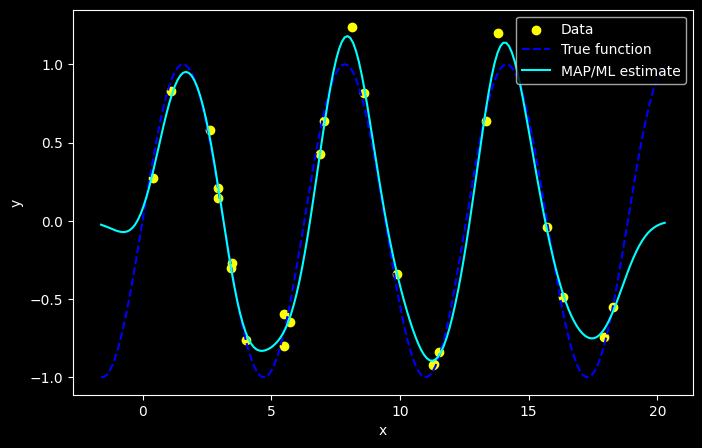

In [ ]:
# Generate new data points for visualization
num_x_test = 200
x_test = np.linspace(x.min() - 2, x.max() + 2, num_x_test)
x_test_kernel = rbf_kernel(x_test, x, sigma_k)

# Virtual samples for testing
v_samples_test = x_test_kernel @ eigenvectors @ np.diag(1 / np.sqrt(eigenvalues))
print(f'v_samples_test shape: {v_samples_test.shape}')

print(x_test_kernel[-5:,-5:])
print((v_samples_test@v_samples_train.T)[-5:,-5:])

# Prediction using MAP estimator
y_test = v_samples_test @ theta_map

fig_1, ax_1 = plt.subplots(figsize=(8, 5))

ax_1.scatter(x, y, label='Data', color='yellow')
ax_1.plot(x_test, np.sin(x_test), label='True function', color='blue', linestyle='--')
ax_1.plot(x_test, y_test, label='MAP/ML estimate', color='cyan', linestyle='-')
ax_1.set_xlabel('x')
ax_1.set_ylabel('y')
ax_1.legend()
plt.show()

In [ ]:
print(rbf_kernel(x_test, x_test, sigma_k)[-5:, -5:])
print((v_samples_test@v_samples_test.T)[-5:, -5:])

[[ 1.00e+00  9.93e-01  9.71e-01  9.35e-01  8.87e-01]
 [ 9.93e-01  1.00e+00  9.93e-01  9.71e-01  9.35e-01]
 [ 9.71e-01  9.93e-01  1.00e+00  9.93e-01  9.71e-01]
 [ 9.35e-01  9.71e-01  9.93e-01  1.00e+00  9.93e-01]
 [ 8.87e-01  9.35e-01  9.71e-01  9.93e-01  1.00e+00]]
[[ 1.29e-01  1.07e-01  8.67e-02  6.93e-02  5.45e-02]
 [ 1.07e-01  8.82e-02  7.18e-02  5.74e-02  4.52e-02]
 [ 8.67e-02  7.18e-02  5.84e-02  4.68e-02  3.68e-02]
 [ 6.93e-02  5.74e-02  4.68e-02  3.74e-02  2.95e-02]
 [ 5.45e-02  4.52e-02  3.68e-02  2.95e-02  2.32e-02]]


#### Sampling from $p(\theta|D)$ using Metropolis algorithm

In [ ]:
def posterior(theta, v_samples_train, y, sigma_d, sigma_theta):
    # this function computes p(theta|D) for given theta
    y_pred = v_samples_train @ theta
    prior = np.exp(-0.5 * np.sum(theta**2) / (sigma_theta**2 ))
    likelihood = np.exp(-0.5 * np.sum((y_pred - y)**2) / (sigma_d**2 ))
    posterior_val = prior * likelihood
    # print(f"Theta: {theta[:5]}, Prior: {prior:.4e}, Likelihood: {likelihood:.4e}, Posterior: {posterior_val:.4e}")
    return posterior_val

def metropolis(posterior, initial_theta, proposal_cov, num_samples, v_samples_train, y, sigma_d, sigma_theta):
    samples = []
    acceptance_history = []
    posterior_history = []
    accepted = 0

    theta_current = initial_theta
    posterior_current = posterior(theta_current, v_samples_train, y, sigma_d, sigma_theta)
    posterior_history.append(posterior_current)

    for i in range(num_samples):
        theta_proposal = np.random.multivariate_normal(theta_current, proposal_cov)
        posterior_proposal = posterior(theta_proposal, v_samples_train, y, sigma_d, sigma_theta)
        acceptance_prob = posterior_proposal / (posterior_current)

        # print(f"Iteration {i}, Posterior Current: {posterior_current:.4e}, Posterior Proposal: {posterior_proposal:.4e}, Acceptance Prob: {acceptance_prob:.4e}")

        acceptance_history.append(acceptance_prob)
        if np.random.rand() < acceptance_prob:
            accepted += 1
            theta_current = theta_proposal
            posterior_current = posterior_proposal

        samples.append(theta_current)
        posterior_history.append(posterior_current)

    acceptance_rate = accepted / num_samples
    print(f"Metropolis acceptance rate: {acceptance_rate:.2f}")

    return np.array(samples), np.array(acceptance_history), np.array(posterior_history)

Metropolis acceptance rate: 0.28
theta_samples shape: (500, 24)
x_test_kernel shape: (200, 24)
y_samples shape: (200, 500)


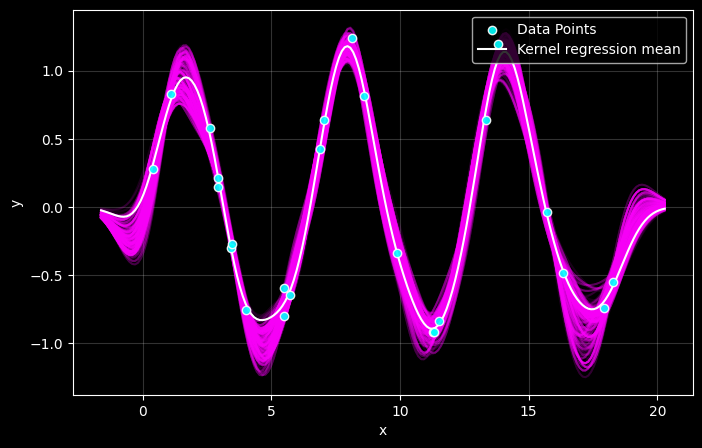

In [ ]:
# np.random.seed(42)

sampling_methods = ['laplace', 'metropolis']
sampling = 'metropolis'

if sampling not in sampling_methods:
    raise ValueError(f"Invalid sampling method: {sampling}. Allowed methods are {sampling_methods}.")

num_samples = 500

if sampling == 'metropolis':

    # likelihood function is very small, the step size needs to be small
    proposal_cov = np.eye(theta_map.shape[0]) * 2e-3
    initial_theta = theta_map # + np.random.normal(0, 1, theta_map.shape[0])
    theta_samples, acceptance_history, posterior_history = metropolis(
        posterior=posterior,
        initial_theta=initial_theta,
        proposal_cov=proposal_cov,
        num_samples=num_samples,
        v_samples_train=v_samples_train,
        y=y,
        sigma_d=sigma_d,
        sigma_theta=sigma_theta
    )

    # print("Acceptance History (first 100):", acceptance_history[:100])
    # print("Posterior History (first 100):", posterior_history[:100])

elif sampling == 'laplace':
    # Compute inverse of full Hessian matrix
    hessian = v_samples_train.T @ v_samples_train/ sigma_d**2 + np.eye(v_samples_train.shape[1]) / sigma_theta**2
    # Ensure symmetry
    hessian = (hessian + hessian.T) / 2
    # Add a small identity matrix to ensure positive semi-definiteness
    hessian += np.eye(hessian.shape[0]) * 1e-7
    h_mat = np.linalg.inv(hessian)
    print(f'hessian shape: {hessian.shape}')
    print(f'hessian is positive semi-definite: {np.all(np.linalg.eigvals(hessian) > 0)}')

    # Sample from the approximate posterior p(theta|D)
    theta_samples = np.random.multivariate_normal(theta, h_mat, num_samples)

print(f'theta_samples shape: {theta_samples.shape}')
print(f'x_test_kernel shape: {v_samples_test.shape}')

# Visualize uncertainty
y_samples = v_samples_test @ theta_samples.T  # (n_x_test, n_theta_samples)
print(f'y_samples shape: {y_samples.shape}')

fig_3, ax_3 = plt.subplots(figsize=(8, 5))
ax_3.scatter(x, y, color='cyan', label='Data Points', alpha=0.9, edgecolors='w',zorder=10)
for i in range(num_samples):
    ax_3.plot(x_test, y_samples.T[i], color='magenta', alpha=0.1)
ax_3.plot(x_test, y_test, color='white', label='Kernel regression mean')
ax_3.set_xlabel('x')
ax_3.set_ylabel('y')
ax_3.legend(loc='upper right')
ax_3.grid(True, alpha=0.2)
plt.show()

#### Bayesian marginalization (numerical)

In [ ]:
# Posterior mean and variance for prediction (numerical)
posterior_mean_y = np.zeros(len(v_samples_test))
posterior_var_y = np.zeros(len(v_samples_test))

num_samples_predictive_per_theta = 5

for i, x_ in enumerate(v_samples_test):
    predictive_samples = []
    for theta_sample in theta_samples:
        predictive_mean = v_samples_test[i, :] @ theta_sample
        predictive_var = sigma_d**2
        individual_pred_dist = np.random.normal(predictive_mean, np.sqrt(predictive_var), num_samples_predictive_per_theta)
        predictive_samples.extend(individual_pred_dist)

    posterior_mean_y[i] = np.mean(predictive_samples)
    posterior_var_y[i] = np.var(predictive_samples)

k_star_star = rbf_kernel(x_test, x_test, sigma_k)

# This step corrects posterior variance
posterior_var_y = posterior_var_y - np.diag(v_samples_test@v_samples_test.T) + np.diag(k_star_star)
posterior_std_y = np.sqrt(posterior_var_y)

#### Bayesian marginalization (analytical, as reference for comparison)

In [ ]:
use_formula = '2.12'

if use_formula == '2.12':
    # Compute posterior mean and covariance using kernel in original space, eq. 2.12, in Rasmussen and Williams's Gaussian process book
    H_mat = x_k + np.eye(x_k.shape[0]) * sigma_d**2

    H_mat = (H_mat + H_mat.T) / 2
    H_mat += np.eye(H_mat.shape[0]) * 1e-6 # for numerical stability
    H_mat_inv = np.linalg.inv(H_mat)

    analytical_mean_y = x_test_kernel @ H_mat_inv @ y
    cov_mat = rbf_kernel(x_test, x_test, sigma_k) - x_test_kernel @ H_mat_inv @ x_test_kernel.T

    analytical_std_y = np.sqrt((np.diagonal(cov_mat)))

elif use_formula == '2.11':
    # Compute covariance using virtual sample in feature space, eq. 2.11 in RW's GP book
    A_mat = v_samples_train.T @ v_samples_train / sigma_d**2 + np.eye(v_samples_train.shape[1]) / sigma_theta**2

    A_mat = (A_mat + A_mat.T) / 2
    A_mat += np.eye(A_mat.shape[0]) * 1e-6 # for numerical stability
    A_mat_inv = np.linalg.inv(A_mat)

    analytical_mean_y = 1/ sigma_d**2 * v_samples_test @ A_mat_inv @ v_samples_train.T @ y

    k_star_star = rbf_kernel(x_test, x_test, sigma_k)

    cov_mat_feature = v_samples_test @ A_mat_inv @ v_samples_test.T

    # This step corrects posterior variance
    cov_mat = cov_mat_feature - v_samples_test @ v_samples_test.T + k_star_star

    analytical_std_y = np.sqrt((np.diagonal(cov_mat)))

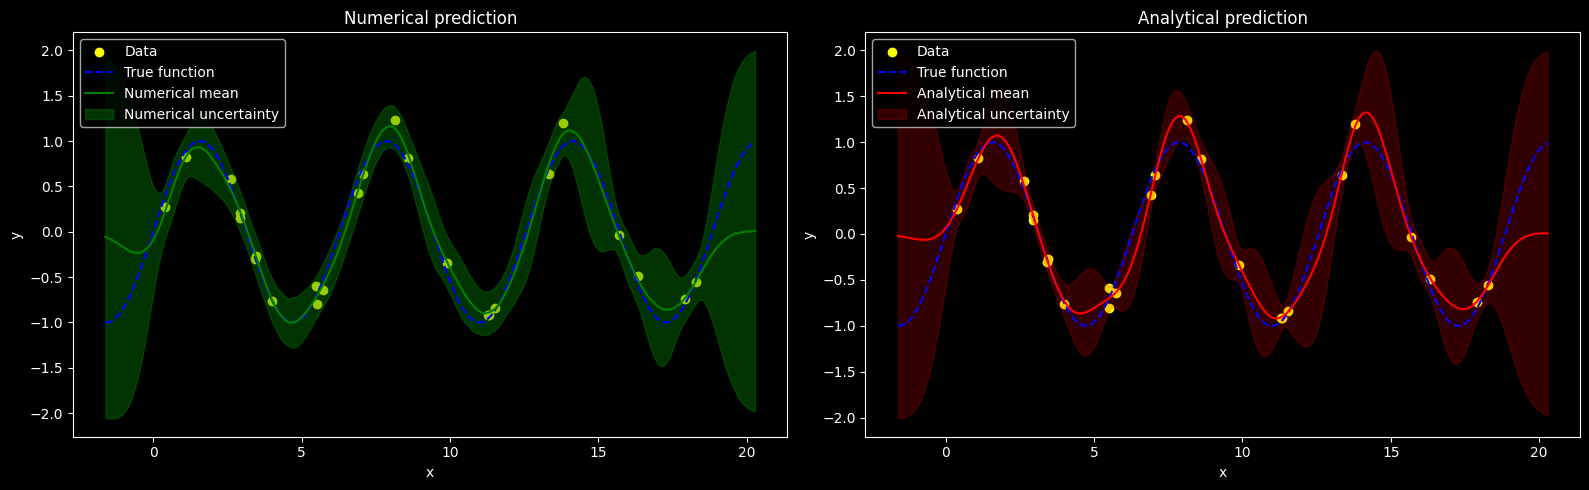

In [ ]:
fig_4, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot numerical posterior mean and uncertainty
axes[0].scatter(x, y, label='Data', color='yellow')
axes[0].plot(x_test, np.sin(x_test), label='True function', color='blue', linestyle='--')
axes[0].plot(x_test, posterior_mean_y, label='Numerical mean', color='green')
axes[0].fill_between(x_test,
                     posterior_mean_y - 2 * posterior_std_y,
                     posterior_mean_y + 2 * posterior_std_y,
                     color='green', alpha=0.4, label='Numerical uncertainty')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Numerical prediction')
axes[0].legend(loc='upper left')

# Plot analytical posterior mean and uncertainty
axes[1].scatter(x, y, label='Data', color='yellow')
axes[1].plot(x_test, np.sin(x_test), label='True function', color='blue', linestyle='--')
axes[1].plot(x_test, analytical_mean_y, label='Analytical mean', color='red')
axes[1].fill_between(x_test,
                     analytical_mean_y - 2 * analytical_std_y,
                     analytical_mean_y + 2 * analytical_std_y,
                     color='red', alpha=0.2, label='Analytical uncertainty')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('Analytical prediction')
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.show()